In [1]:
import numpy as np
import pandas as pd
import glob
from datetime import timedelta
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import itertools
import warnings
import matplotlib.pyplot as plt
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
def is_nan(x):
    '''
    Checks if x is nan or not.
    Taken from https://stackoverflow.com/questions/944700/how-can-i-check-for-nan-values.

    :param x: any type of item to check for if it is nan type

    Returns True if it is nan type, false if not.
    '''

    return (x is np.nan or x != x)

In [3]:
def create_df_per_patient(filename):
    df_patient = pd.read_csv(filename)
    # Edit dataframe
    #df_patient['month'] = df_patient.apply(lambda row: row.time[5:7], axis=1)
    #df_patient['day'] = df_patient.apply(lambda row: row.time[8:10], axis=1)
    #df_patient['call'].fillna(0, inplace=True)

    # Remove rows with no value for mood for whole day
    df_patient = df_patient[is_nan(df_patient['mood']) != True]
    df_patient = df_patient[is_nan(df_patient['screen']) != True]
    df_patient.fillna(0, inplace=True)
    df_patient['time'] = pd.to_datetime(df_patient['time'])
    df_patient.set_index(['time'], inplace=True)
    return df_patient

def generate_instances(df, columns=['mood']):
    number_of_days = 6
    all_instances = []
    all_labels = []
    for date_0, row_0 in df.iterrows():
        valid_data_count = 0
        instance = []
        for date, row in df.iterrows():
            for delta_days in range(1, number_of_days):
                #print(delta_days)
                if date_0 - timedelta(days=delta_days) == date:
                    selected_day_info = list(row[columns])
                    instance += selected_day_info
                    if not is_nan(row['mood']):
                        valid_data_count += 1
                    
        if valid_data_count == number_of_days-1:
            all_labels.append(row_0['mood'])
            all_instances.append(instance)

    assert len(all_labels)==len(all_instances), 'Amount of instances and amount of labels differ.'
    assert len(all_instances) > 0, 'No instances were created.'

    return all_instances, all_labels

def train_and_eval(instances, labels, model='svr'):
    X_train, X_test, y_train, y_test = train_test_split(instances, labels, test_size=0.33, random_state=42)
    if model=='svr':
        # Make instance of model svm.SVR
        clf = svm.SVR().fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    error = mean_squared_error(y_test, y_pred)
    return error

def find_best_features(feature_selection_list, df, filepath, model_selection_list=['svr']):
    # set scoring dict
    score_dict = dict()
    # Loop through feature combinations and models
    for features in feature_selection_list:
        for model in model_selection_list:
            # Generate training instances
            all_instances, all_labels = generate_instances(df, columns=features)
            # Train and evaluate
            score = train_and_eval(all_instances, all_labels, model=model)
            # Write to dictionary
            key = tuple([tuple(features), model])
            score_dict[key] = score
            # Sort dictionary
            sorted_dict = sorted(score_dict.items(), key=lambda x:x[1])
            # Write to file
            with open(filepath, 'w') as outfile:
                for item in sorted_dict:
                    outfile.write(str(item)+'\n')

In [ ]:
filename_patient_7 = './patientData/patientAS14.07.csv'
filename_patient_2 = './patientData/patientAS14.02.csv'

df_7 = create_df_per_patient(filename_patient_7)
df_2 = create_df_per_patient(filename_patient_2)
df_7

In [19]:
filename_patient = './patientData/patientAS14.07.csv'
def show_plot_patient(filename_patient):
    patient_id = filename_patient[-6:-4]

    df = create_df_per_patient(filename_patient)

    instances, labels = generate_instances(df, columns=['circumplex.valence', 'circumplex.arousal', 'mood', 'sms'])

    X_train, X_test, y_train, y_test = train_test_split(instances, labels, test_size=0.33, random_state=42)
    clf = svm.SVR().fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    plt.plot(y_pred) # Blue
    plt.plot(y_test) # Orange
    plt.ylim(4, 10)
    plt.title(f'True and predicted mood for client {patient_id}')
    plt.show

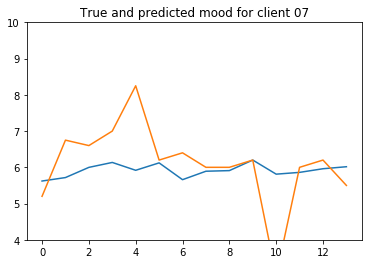

In [20]:
show_plot_patient('./patientData/patientAS14.07.csv')

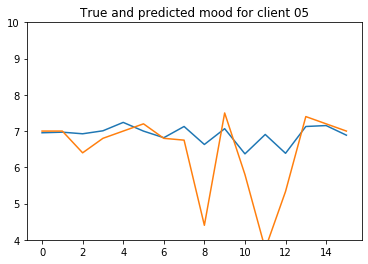

In [21]:
show_plot_patient('./patientData/patientAS14.05.csv')

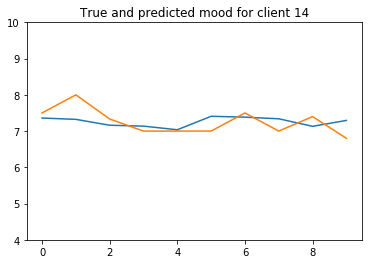

In [22]:
show_plot_patient('./patientData/patientAS14.14.csv')

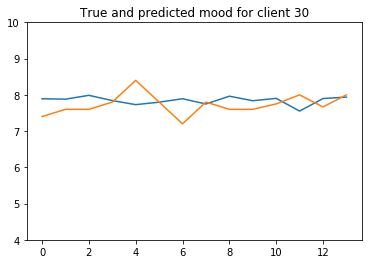

In [23]:
show_plot_patient('./patientData/patientAS14.30.csv')

In [ ]:
# For all patients
errors = []
all_instances = []
all_labels = []
model = 'svr'
score_dict = dict()
patient_filenames = glob.glob('./patientData/*')
features = ['circumplex.arousal', 'circumplex.valence', 'mood', 'sms']

for filename_patient in patient_filenames:
    print(filename_patient)
    df_patient = create_df_per_patient(filename_patient)
    #print(df_patient)
    # Generate instances
    all_instances = []
    all_labels = []
    patient_instances, patient_labels = generate_instances(df_patient, columns=features)
    all_instances += patient_instances
    all_labels += patient_labels

# Train and evaluate
score = train_and_eval(all_instances, all_labels, model=model)
score

    
# errors.append(error)
# errors
